# Lab 5. Outliers Detection

![Outliers](./Outliers.jpeg)

## Bayesian modeling 

In [5]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import scipy as sp
import pandas as pd
import seaborn as sns
import warnings
sns.set_style('darkgrid')
plotBlue = sns.color_palette()[0]
np.random.seed(3)
warnings.filterwarnings("ignore")

### Normally Distributed Single Variable

In this section, we will see how anomaly detection can work for observations with a single feature.

The simplest possible case for anomaly detection is observational data with a single, normally distributed feature. We'll generate 1000 such observations.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


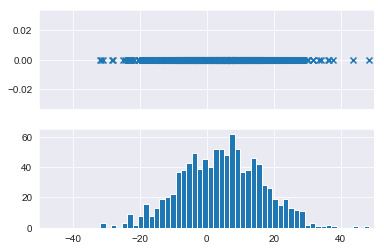

In [6]:
N = 1000
X1 = np.random.normal(4, 12, N)
f, axes = plt.subplots(nrows=2, sharex=True)
axes[0].set_xlim(-50, 50)
axes[0].scatter(X1, np.zeros(N), marker='x', c=plotBlue)
axes[1].hist(X1, bins=50)
plt.show()

To model this data as a normal distribution, we take the mean and the standard deviation from the sample we have.

In [7]:
sample_mean = X1.mean()
sample_sigma = X1.std()
print('Sample Mean:', sample_mean)
print('Sample Standard Deviation:', sample_sigma)

Sample Mean: 4.207411995770011
Sample Standard Deviation: 12.100822788615268


Our estimate for the distribution therefore looks like this:

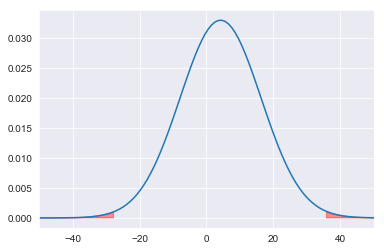

Lower Bound: -27.012710798857384
Upper Bound: 35.4275347903974


In [8]:
base = np.linspace(-50, 50, 100)
normal = sp.stats.norm.pdf(base, sample_mean, sample_sigma)
lower_bound = sample_mean - (2.58 * sample_sigma)
upper_bound = sample_mean + (2.58 * sample_sigma)
anomalous = np.logical_or(base < [lower_bound]*100, base > [upper_bound]*100)

plt.plot(base, normal)
plt.fill_between(base, normal, where=anomalous, color=[1, 0, 0, 0.4])
plt.xlim(-50, 50)
plt.show()
print('Lower Bound:', lower_bound)
print('Upper Bound:', upper_bound)

Now we just have to decide on some 'epsilon' value, which dictates our probability threshold for anomalous events.  If we set epsilon to .01, we're saying that any draw for which there's a probability of 1% or less that it given the above distribution should be marked as anomalous.  These values are the upper and lower bounds for what we consider 'normal', and are represented in the graphs above by the area shaded in red.

Let's look at two sample draws to see if they're anomalous.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


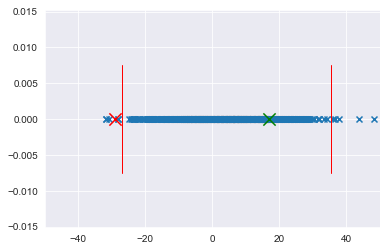

In [9]:
plt.scatter(X1, np.zeros(N), marker='x', c=plotBlue)
plt.xlim(-50, 50)
plt.scatter(-29, 0, marker='x', color='red', s=150, linewidths=3)
plt.scatter(17, 0, marker='x', color='green', s=150, linewidths=3)
plt.axvline(lower_bound, ymin=.25, ymax=.75, color='red', linewidth=1)
plt.axvline(upper_bound, ymin=.25, ymax=.75, color='red', linewidth=1)
plt.show()

Here we can see that the red draw exceeds the lower bound, and would therefore come up as anomalous, whereas the green draw falls within the normal range.

Note that we’re losing some uncertainty by doing it this way.  We’re using the sample mean and standard deviation directly as estimates for the population mean and standard deviation, but of course there is some uncertainty in those estimates.  This model has no mechanism for preserving that uncertainty; we get the same probability estimate for any given event regardless of how certain we are about our estimates for those parameters.

### Non-normally distributed single variable

In this section, we’ll look at a slightly more complicated case, in which we have observations with a single feature that are not normally distributed.  This will demonstrate two additional shortcomings of the standard approach to anomaly detection.  First, we’ll have to manually manipulate the data to ‘look’ normal.  Second, there is no simple way to encode pre-existing knowledge about the distributions into the model.

Imagine that our observations can only take on positive values, which is a common restriction. For simplicity, let's use the same observations we used earlier, but we'll simply drop all negative observations.

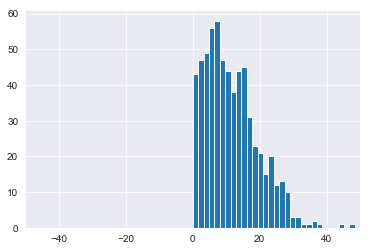

In [10]:
X2 = X1[X1 > 0]
plt.hist(X2, bins=30)
plt.xlim(-50, 50)
plt.show()

Just looking at the data, it seems that it no longer makes sense to model these observations as normally distributed.  Let's see what happens if we do try to model this as a normal distribution:

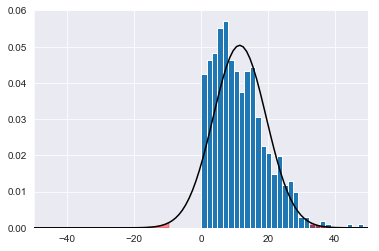

Lower Bound: -8.864199297811245
Upper Bound: 31.983896877339994


In [11]:
sample_mean = X2.mean()
sample_sigma = X2.std()
base = np.linspace(-50, 50, 100)
normal = sp.stats.norm.pdf(base, sample_mean, sample_sigma)
lower_bound = sample_mean - (2.58 * sample_sigma)
upper_bound = sample_mean + (2.58 * sample_sigma)
anomalous = np.logical_or(base < [lower_bound]*100, base > [upper_bound]*100)

plt.hist(X2, bins=30, normed=True, zorder=1)
plt.fill_between(base, normal, where=anomalous, color=[1, 0, 0, 0.4], zorder=2)
plt.plot(base, normal, color='black', zorder=3)
plt.xlim(-50, 50)
plt.show()
print('Lower Bound:', lower_bound)
print('Upper Bound:', upper_bound)

Clearly this distribution does not fit our data!  Most obviously, it wouldn't declare an observation anomalous until it was less than ~ -8.9, while we already know that anything less than 0 is highly anomalous.  When we get into bayesian analysis and probabilistic programming we'll see how we can encode this prior knowledge into our models.

In the meanwhile, one common work around is to transform the observations until they look vaguely like they come from a normal distribution.  Common approaches for positive distributions include taking the logarithm of every observation, or raising it to a power less than 1.  With this data, it turns out that raising each observation to 0.55 produces something roughly normal.

Though this is common practice, especially in low-lift anomaly detection systems, eyeballing distribution transformations should make you suspicious.  It results in haphazard analysis and fuzzy statistical reasoning.  Again, probabilistic programming will give us the tools to make sure that all parameters we use in our model are calculated using legitimate statistical methods.

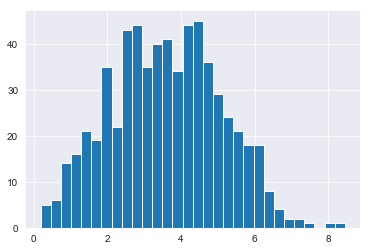

In [13]:
X3 = X2 ** 0.55
plt.hist(X3, bins=30)
plt.show()

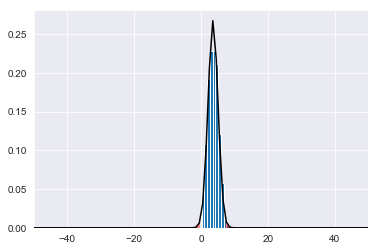

Lower Bound: -0.2523023180285473
Upper Bound: 7.442065881514468


In [14]:
sample_mean = X3.mean()
sample_sigma = X3.std()
base = np.linspace(-50, 50, 100)
normal = sp.stats.norm.pdf(base, sample_mean, sample_sigma)
lower_bound = sample_mean - (2.58 * sample_sigma)
upper_bound = sample_mean + (2.58 * sample_sigma)
anomalous = np.logical_or(base < [lower_bound]*100, base > [upper_bound]*100)

plt.hist(X3, bins=10, normed=True, zorder=1)
plt.fill_between(base, normal, where=anomalous, color=[1, 0, 0, 0.4], zorder=2)
plt.plot(base, normal, color='black', zorder=3)
plt.xlim(-50, 50)
plt.show()
print('Lower Bound:', lower_bound)
print('Upper Bound:', upper_bound)

### Multiple Independently Distributed Normal Variables

So far we've only been looking at observations with a single feature. We'll now expand our analysis to multiple variables. Initially we will assume that they are independently normal distributed. That is, that each feature is normally distributed, and there is no correlation between them.  Though this is still a simple example, this simple multi-dimensional case will set the stage for evaluating how the traditional methods of anomaly detection perform on more realistic data. 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


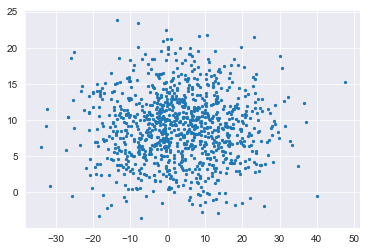

In [15]:
N = 1000
X1 = np.random.normal(4, 12, N)
X2 = np.random.normal(9, 5, N)
plt.scatter(X1, X2, c=plotBlue, s=5)
plt.show()

In [16]:
x1_sample_mean = X1.mean()
x2_sample_mean = X2.mean()
x1_sample_sigma = X1.std()
x2_sample_sigma = X2.std()
print('Sample Mean 1:', x1_sample_mean)
print('Sample Mean 2:', x2_sample_mean)
print('Sample Standard Deviation 1:', x1_sample_sigma)
print('Sample Standard Deviation 2:', x2_sample_sigma)

Sample Mean 1: 3.0795712898444316
Sample Mean 2: 9.020050102068952
Sample Standard Deviation 1: 12.138245899659257
Sample Standard Deviation 2: 4.7692467920799775


As we would expect, these are not far from the actual values we used to generate the data.

Next, let's look at a heatmap of where we would expect to find observations given the joint probability distributions implied by these distributions.

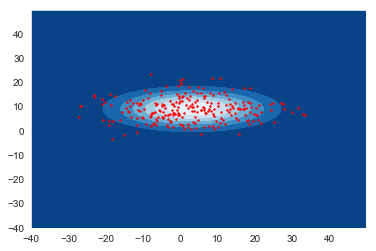

In [17]:
delta = 0.3
x1 = np.arange(-40, 50, delta)
x2 = np.arange(-40, 50, delta)
x, y = np.meshgrid(x1, x2)
z = plt.mlab.bivariate_normal(x, y, x1_sample_sigma, x2_sample_sigma, x1_sample_mean, x2_sample_mean)
plt.contourf(x, y, z, cmap='Blues_r')
thinned_points = np.array([n in np.random.choice(N, 300) for n in range(N)])
plt.scatter(X1[thinned_points], X2[thinned_points], c='red', s=2)
plt.show()

Because the two variables are independent, we get this nice concentric circle shape, where as we move in towards the means, we're increasingly likely to draw an observation with those features. As we move away, we're less likely to see an observation with features at those values. We might, for instance, decide that anything in the dark-blue region is anomalous.

Note that because the distribution of the vertical feature has a smaller variance, the area of high probability is much thinner vertically than it is horizontally.

### Multiple Jointly Distributed Features

In this section, we’ll look at some slightly more realistic data.  We will try to use some of the methods we’ve built up to this point to tackle this more complex data.  

To build up more of an intuition of what’s going on, let's say that we're observing database transactions, and for each observation we record the latency and the average number of concurrent connections over the course of the transaction.

We expect these to be positively correlated - the database takes longer to process any given query as the number of active connections grows.  

We also know that neither of these features can be negative - you cannot have fewer than zero connections to the database, and you cannot finish a transaction before you start it (negative latency).

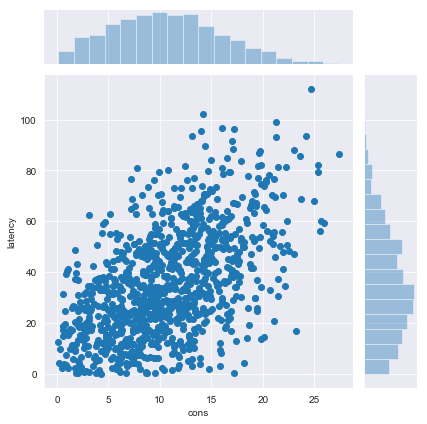

In [18]:
def positive_support_normal(mean, sigma, n):
    xs = np.random.normal(mean, sigma, n)
    for i, num in enumerate(xs):
        while num < 0:
            num = np.random.normal(mean[i], sigma)
        xs[i] = num
    return xs
    
N = 1000

mu_cons = 10
sigma_cons = 6
sigma_latency = 20
beta = 3

cons = positive_support_normal(np.array([mu_cons]*N), sigma_cons, N)
latency = positive_support_normal(beta * cons, sigma_latency, N)
ax = sns.jointplot('cons', 'latency', pd.DataFrame({'cons': cons, 'latency': latency}))

Now if we use our previous method - where we treat each feature as independently normally distributed - to think about the probability of finding observations with a particular combination of features, we'll see something like this:

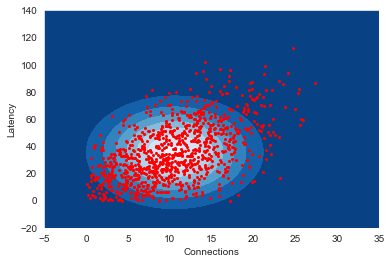

In [19]:
delta = 0.025
x1 = np.arange(-5, 35, delta)
x2 = np.arange(-20, 140, delta)
x, y = np.meshgrid(x1, x2)
z = plt.mlab.bivariate_normal(x, y, cons.std(), latency.std(), cons.mean(), latency.mean())
plt.contourf(x, y, z, cmap='Blues_r')
plt.scatter(cons, latency, c='red', s=4)
plt.ylabel('Latency')
plt.xlabel('Connections')
plt.show()

The problem is that we're missing something about the relationship between the two features.  We _know_ that latency depends on the number of concurrent connections, but it's difficult to account for that in our model.

There are a few ways to address this issue.  For example, we could engineer a new feature from the existing data that might capture some of the correlation between the two, and treat that as independently normally distributed as well. Alternatively, we could use the observed data to estimate the covariance relation between the two features and keep trying to model them as a multivariate normal distribution.

Any of these steps quickly get complicated and, more importantly, imprecise.  So far we've only explored relatively simple distributions with very small numbers of features.  Each feature needs to be  be transformed somehow to the normal.  We might need to build new features by hand to improve our models properties, and most often we'll assume that if features are correlated, they at least have joint normal distributions.

Assumptions about distributions are a good place to start, but we should be able to learn from the data in a more robust and systematic way than eyeballing the value of added features or distribution transformations.

That's exactly where Bayesian modeling and probabilistic programming come in.

Bayesian modeling is a way of calculating the likelihood of some observation, given the data you've already seen.  It allows you to declare your statistical beliefs about what your data _should_ look like before you look at the data.  These beliefs are known as 'priors'.  You can declare one for each of the parameters you're interested in estimating. Bayesian modeling looks at these priors and the observed data, and calculates a distribution for each of those parameters.  These are known as 'posterior distributions'.  

Part of the benefit of probabilistic programming, relative to comparable Bayesian modeling in the past, is that you don't need to know anything about how that calculation happens.

### Probabilistic Programming

Roughly speaking, the steps involved in probabilistic programming are as follows:

1. Declare your prior beliefs about what the data looks like.
2. Feed in your data.
3. A sampling algorithm will return a posterior distribution for each of the parameters in your model.

Probabilistic programming languages enable you to state your priors beliefs and your model with elegant, statistical syntax.  

The more data you have to learn from, the less your prior beliefs matter, and generally the tighter the distributions you'll get for your model parameters.

There are several advantages here.  First, you get a formal way to encode your knowledge about the data into your model.  As we saw earlier, this is especially useful when you know that there is no chance at all of certain observations.

Second, there are no limitations on which distributions we can use to model our world, or on the hierarchical relations we claim they have.  Which  means, among other things, that and we don't have to estimate data manipulations to make things look right.

Third, we get to propagate our uncertainty.  For example, instead of simply estimating the mean of the population distribution as the sample mean, we estimate the population mean as a distribution itself, and the nature of this uncertainty will affect our final model of the data.

It's simpler than ever to build a complex model of the world.

## Graded Part

[PyMC Linear Regression example](https://docs.pymc.io/notebooks/GLM-linear.html)

In [20]:
%matplotlib inline
%qtconsole --colors=linux

import warnings
warnings.filterwarnings('ignore')

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import optimize
import pymc3 as pm
import theano as thno
import theano.tensor as T 

sns.set(style="darkgrid", palette="muted")
pd.set_option('display.notebook_repr_html', True)
plt.rcParams['figure.figsize'] = 12, 8
np.random.seed(0)

In [22]:
dfhogg = pd.DataFrame(np.array([[1, 201, 592, 61, 9, -0.84],
                                 [2, 244, 401, 25, 4, 0.31],
                                 [3, 47, 583, 38, 11, 0.64],
                                 [4, 287, 402, 15, 7, -0.27],
                                 [5, 203, 495, 21, 5, -0.33],
                                 [6, 58, 173, 15, 9, 0.67],
                                 [7, 210, 479, 27, 4, -0.02],
                                 [8, 202, 504, 14, 4, -0.05],
                                 [9, 198, 510, 30, 11, -0.84],
                                 [10, 158, 416, 16, 7, -0.69],
                                 [11, 165, 393, 14, 5, 0.30],
                                 [12, 201, 442, 25, 5, -0.46],
                                 [13, 157, 317, 52, 5, -0.03],
                                 [14, 131, 311, 16, 6, 0.50],
                                 [15, 166, 400, 34, 6, 0.73],
                                 [16, 160, 337, 31, 5, -0.52],
                                 [17, 186, 423, 42, 9, 0.90],
                                 [18, 125, 334, 26, 8, 0.40],
                                 [19, 218, 533, 16, 6, -0.78],
                                 [20, 146, 344, 22, 5, -0.56]]),
                   columns=['id','x','y','sigma_y','sigma_x','rho_xy'])

In [23]:
dfhogg['id'] = dfhogg['id'] - 1
dfhogg.set_index('id', inplace=True)

In [24]:
## standardize (mean center and divide by 1 sd)
dfhoggs = (dfhogg[['x', 'y']]-dfhogg[['x', 'y']].mean(0))/dfhogg[['x', 'y']].std(0)
dfhoggs['sigma_y'] = dfhogg['sigma_y']/dfhogg['y'].std(0)
dfhoggs['sigma_x'] = dfhogg['sigma_x']/dfhogg['x'].std(0)

In [25]:
xlims = (dfhoggs['x'].min() - np.ptp(dfhoggs['x'])/5
                 ,dfhoggs['x'].max() + np.ptp(dfhoggs['x'])/5)
ylims = (dfhoggs['y'].min() - np.ptp(dfhoggs['y'])/5
                 ,dfhoggs['y'].max() + np.ptp(dfhoggs['y'])/5)

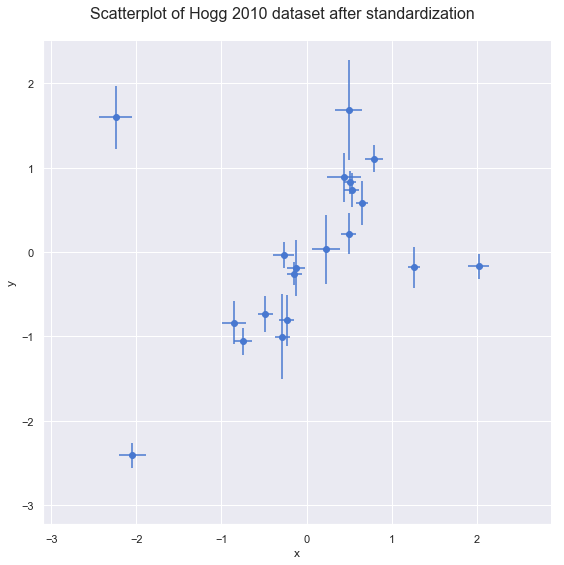

In [26]:
g = sns.FacetGrid(dfhoggs, size=8)
_ = g.map(plt.errorbar, 'x', 'y', 'sigma_y', 'sigma_x', marker="o", ls='')
_ = g.axes[0][0].set_ylim(ylims)
_ = g.axes[0][0].set_xlim(xlims)

plt.subplots_adjust(top=0.92)
_ = g.fig.suptitle('Scatterplot of Hogg 2010 dataset after standardization', fontsize=16)

### Create Conventional OLS Model

The *linear model* is really simple and conventional:

$$\bf{y} = \beta^{T} \bf{X} + \bf{\sigma}$$

where:  

$\beta$ = coefs = $\{1, \beta_{j \in X_{j}}\}$  
$\sigma$ = the measured error in $y$ in the dataset `sigma_y`

##### Define model

**NOTE:**
+ We're using a simple linear OLS model with Normally distributed priors so that it behaves like a ridge regression

In [27]:
with pm.Model() as mdl_ols:
    
    ## Define weakly informative Normal priors to give Ridge regression
    b0 = pm.Normal('b0_intercept', mu=0, sd=100)
    b1 = pm.Normal('b1_slope', mu=0, sd=100)
 
    ## Define linear model
    yest = b0 + b1*dfhoggs['x']
    
    ## Use y error from dataset, convert into theano variable
    sigma_y = thno.shared(np.asarray(dfhoggs['sigma_y'],
                            dtype=thno.config.floatX), name='sigma_y')

    ## Define Normal likelihood:
    ## mu = yest
    ## sd = sigma_y
    ## odserved = dfhoggs['y']
    likelihood = pm.Normal('likelihood',  mu=yest, sd=sigma_y, observed=dfhoggs['y'])

In [28]:
with mdl_ols:

    ## find MAP using Powell, seems to be more robust
    start_MAP = pm.find_MAP(fmin=optimize.fmin_powell, disp=True)

    ## take samples
    traces_ols = pm.sample(2000, start=start_MAP, step=pm.NUTS(), progressbar=True)

  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]

logp = -248.97:   0%|                                                                         | 0/5000 [00:00<?, ?it/s]

logp = -154.74:   0%|▏                                                              | 10/5000 [00:00<00:04, 999.83it/s]

logp = -145.8:   0%|▎                                                               | 20/5000 [00:00<00:04, 999.74it/s]

logp = -387.53:   1%|▍                                                              | 30/5000 [00:00<00:05, 937.36it/s]

logp = -145.8:   1%|▌                                                               | 40/5000 [00:00<00:05, 869.46it/s]

logp = -778.17:   1%|▋                                                              | 50/5000 [00:00<00:05, 925.83it/s]

logp = -145.78:   1%|▊                                                              | 60/5000 [00:00<00:05, 937.42it/s]

logp = -145.78:   1%|▉                                                              | 70/5000 [00:00<00:05, 897.40it/s]

logp = -145.78:   2%|█                                                              | 80/5000 [00:00<00:05, 941.08it/s]

logp = -145.78:   2%|█▏                                                             | 90/5000 [00:00<00:05, 927.78it/s]

logp = -145.78:   2%|█▏                                                             | 91/5000 [00:00<00:05, 909.97it/s]

Optimization terminated successfully.

         Current function value: 145.777745

         Iterations: 3

         Function evaluations: 100

logp = -145.78:   2%|█▎                                                             | 100/5000 [00:01<01:10, 69.21it/s]

Multiprocess sampling (2 chains in 2 jobs)

NUTS: [b1_slope, b0_intercept]

Could not pickle model, sampling singlethreaded.

Sequential sampling (2 chains in 1 job)

NUTS: [b1_slope, b0_intercept]

  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "C:\Users\nekit\Anaconda3\lib\site-packages\joblib\externals\loky\backend\queues.py", line 150, in _feed
    obj_ = dumps(obj, reducers=reducers)
  File "C:\Users\nekit\Anaconda3\lib\site-packages\joblib\externals\loky\backend\reduction.py", line 243, in dumps
    dump(obj, buf, reducers=reducers, protocol=protocol)
  File "C:\Users\nekit\Anaconda3\lib\site-packages\joblib\externals\loky\backend\reduction.py", line 236, in dump
    _LokyPickler(file, reducers=reducers, protocol=protocol).dump(obj)
  File "C:\Users\nekit\Anaconda3\lib\site-packages\joblib\externals\cloudpickle\cloudpickle.py", line 267, in dump
    return Pickler.dump(self, obj)
  File "C:\Users\nekit\Anaconda3\lib\pickle.py", line 409, in dump
    self.save(obj)
  File "C:\Users\nekit\Anaconda3\lib\pickle.py", line 521, in save
    self.save_reduce(obj=obj, *rv)
  File "C:\Users\nekit\Anaconda3\lib\pickle.py", line 634, in save_reduce
    

  0%|▎                                                                                | 8/2500 [00:00<00:39, 63.49it/s]

  1%|▋                                                                               | 22/2500 [00:00<00:33, 74.25it/s]

  2%|█▋                                                                              | 53/2500 [00:00<00:25, 96.02it/s]

  4%|██▉                                                                            | 94/2500 [00:00<00:19, 124.54it/s]

  5%|████                                                                          | 129/2500 [00:00<00:15, 153.97it/s]

  7%|█████▊                                                                        | 187/2500 [00:00<00:11, 197.28it/s]

 10%|███████▌                                                                      | 243/2500 [00:00<00:09, 244.86it/s]

 11%|████████▉                                                                     | 285/2500 [00:00<00:08, 276.01it/s]

 14%|██████████▊                                                                   | 346/2500 [00:00<00:06, 329.73it/s]

 16%|████████████▊                                                                 | 410/2500 [00:01<00:05, 385.84it/s]

 19%|██████████████▋                                                               | 469/2500 [00:01<00:04, 429.59it/s]

 21%|████████████████▎                                                             | 523/2500 [00:01<00:04, 453.05it/s]

 24%|██████████████████▌                                                           | 594/2500 [00:01<00:03, 507.15it/s]

 27%|████████████████████▋                                                         | 665/2500 [00:01<00:03, 554.69it/s]

 29%|██████████████████████▋                                                       | 728/2500 [00:01<00:03, 490.64it/s]

 31%|████████████████████████▌                                                     | 786/2500 [00:01<00:03, 513.05it/s]

 34%|██████████████████████████▌                                                   | 852/2500 [00:01<00:03, 548.40it/s]

 36%|████████████████████████████▍                                                 | 911/2500 [00:01<00:02, 555.51it/s]

 39%|██████████████████████████████▌                                               | 981/2500 [00:02<00:02, 590.68it/s]

 42%|████████████████████████████████▎                                            | 1050/2500 [00:02<00:02, 617.33it/s]

 45%|██████████████████████████████████▍                                          | 1117/2500 [00:02<00:02, 630.46it/s]

 47%|████████████████████████████████████▍                                        | 1182/2500 [00:02<00:02, 594.31it/s]

 50%|██████████████████████████████████████▎                                      | 1243/2500 [00:02<00:02, 590.25it/s]

 53%|████████████████████████████████████████▌                                    | 1315/2500 [00:02<00:01, 623.98it/s]

 55%|██████████████████████████████████████████▌                                  | 1380/2500 [00:02<00:01, 627.90it/s]

 59%|█████████████████████████████████████████████▎                               | 1470/2500 [00:02<00:01, 688.95it/s]

 62%|███████████████████████████████████████████████▍                             | 1542/2500 [00:02<00:01, 648.91it/s]

 65%|██████████████████████████████████████████████████▏                          | 1629/2500 [00:02<00:01, 700.77it/s]

 68%|████████████████████████████████████████████████████▋                        | 1711/2500 [00:03<00:01, 732.73it/s]

 71%|███████████████████████████████████████████████████████                      | 1787/2500 [00:03<00:01, 699.78it/s]

 75%|█████████████████████████████████████████████████████████▍                   | 1864/2500 [00:03<00:00, 719.47it/s]

 78%|███████████████████████████████████████████████████████████▋                 | 1938/2500 [00:03<00:00, 719.16it/s]

 80%|█████████████████████████████████████████████████████████████▉               | 2011/2500 [00:03<00:00, 689.62it/s]

 84%|████████████████████████████████████████████████████████████████▍            | 2091/2500 [00:03<00:00, 719.39it/s]

 87%|██████████████████████████████████████████████████████████████████▋          | 2164/2500 [00:03<00:00, 718.29it/s]

 89%|████████████████████████████████████████████████████████████████████▉        | 2237/2500 [00:03<00:00, 675.67it/s]

 92%|███████████████████████████████████████████████████████████████████████      | 2306/2500 [00:03<00:00, 645.55it/s]

 95%|█████████████████████████████████████████████████████████████████████████▎   | 2381/2500 [00:04<00:00, 671.88it/s]

 98%|███████████████████████████████████████████████████████████████████████████▍ | 2450/2500 [00:04<00:00, 604.28it/s]

100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:04<00:00, 582.34it/s]

  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

  2%|█▌                                                                             | 50/2500 [00:00<00:04, 490.19it/s]

  4%|███                                                                            | 95/2500 [00:00<00:05, 477.40it/s]

  5%|████▏                                                                         | 134/2500 [00:00<00:05, 444.27it/s]

  7%|█████▏                                                                        | 165/2500 [00:00<00:05, 390.20it/s]

  8%|██████                                                                        | 194/2500 [00:00<00:06, 345.97it/s]

  9%|███████▍                                                                      | 237/2500 [00:00<00:06, 366.58it/s]

 12%|█████████                                                                     | 292/2500 [00:00<00:05, 405.52it/s]

 13%|██████████▎                                                                   | 332/2500 [00:00<00:05, 399.02it/s]

 15%|███████████▌                                                                  | 372/2500 [00:00<00:05, 394.59it/s]

 17%|████████████▉                                                                 | 415/2500 [00:01<00:05, 400.07it/s]

 19%|██████████████▍                                                               | 464/2500 [00:01<00:04, 422.28it/s]

 22%|████████████████▊                                                             | 538/2500 [00:01<00:04, 483.77it/s]

 24%|██████████████████▍                                                           | 590/2500 [00:01<00:04, 445.80it/s]

 26%|███████████████████▉                                                          | 638/2500 [00:01<00:04, 444.16it/s]

 27%|█████████████████████▎                                                        | 685/2500 [00:01<00:04, 440.18it/s]

 29%|██████████████████████▉                                                       | 734/2500 [00:01<00:03, 454.03it/s]

 31%|████████████████████████▎                                                     | 781/2500 [00:01<00:03, 446.94it/s]

 33%|█████████████████████████▊                                                    | 827/2500 [00:01<00:03, 449.45it/s]

 35%|███████████████████████████▎                                                  | 875/2500 [00:01<00:03, 455.59it/s]

 37%|█████████████████████████████▏                                                | 936/2500 [00:02<00:03, 493.03it/s]

 40%|███████████████████████████████                                               | 996/2500 [00:02<00:02, 516.85it/s]

 42%|████████████████████████████████▎                                            | 1049/2500 [00:02<00:02, 519.20it/s]

 44%|█████████████████████████████████▉                                           | 1102/2500 [00:02<00:02, 516.28it/s]

 46%|███████████████████████████████████▌                                         | 1155/2500 [00:02<00:02, 505.44it/s]

 49%|█████████████████████████████████████▉                                       | 1232/2500 [00:02<00:02, 561.06it/s]

 52%|███████████████████████████████████████▊                                     | 1292/2500 [00:02<00:02, 572.20it/s]

 55%|██████████████████████████████████████████▎                                  | 1372/2500 [00:02<00:01, 624.19it/s]

 58%|████████████████████████████████████████████▍                                | 1443/2500 [00:02<00:01, 644.15it/s]

 61%|██████████████████████████████████████████████▉                              | 1524/2500 [00:03<00:01, 686.30it/s]

 64%|█████████████████████████████████████████████████▎                           | 1600/2500 [00:03<00:01, 704.90it/s]

 67%|███████████████████████████████████████████████████▌                         | 1674/2500 [00:03<00:01, 715.07it/s]

 70%|██████████████████████████████████████████████████████                       | 1755/2500 [00:03<00:01, 739.09it/s]

 73%|████████████████████████████████████████████████████████▎                    | 1830/2500 [00:03<00:01, 646.36it/s]

 76%|██████████████████████████████████████████████████████████▍                  | 1898/2500 [00:03<00:00, 618.51it/s]

 79%|████████████████████████████████████████████████████████████▍                | 1963/2500 [00:03<00:00, 625.82it/s]

 81%|██████████████████████████████████████████████████████████████▋              | 2035/2500 [00:03<00:00, 647.86it/s]

 84%|████████████████████████████████████████████████████████████████▋            | 2102/2500 [00:03<00:00, 633.93it/s]

 87%|██████████████████████████████████████████████████████████████████▊          | 2171/2500 [00:04<00:00, 649.77it/s]

 90%|█████████████████████████████████████████████████████████████████████▍       | 2255/2500 [00:04<00:00, 695.41it/s]

 94%|████████████████████████████████████████████████████████████████████████▋    | 2362/2500 [00:04<00:00, 777.01it/s]

 99%|████████████████████████████████████████████████████████████████████████████▎| 2478/2500 [00:04<00:00, 862.43it/s]

100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:04<00:00, 576.17it/s]

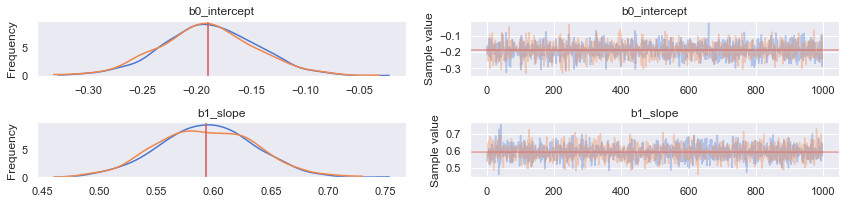

In [29]:
_ = pm.traceplot(traces_ols[-1000:], figsize=(12,len(traces_ols.varnames)*1.5),
                lines={k: v['mean'] for k, v in pm.summary(traces_ols[-1000:]).iterrows()})

### Create Robust Model: Student-T Method

Instead of using a Normal distribution for the likelihood, we use a Student-T, which is heavy-tailed distribution.

**In theory this allows outliers to have a smaller mean square error in the likelihood, and thus have less influence on the regression estimation.**

**Note:** we'll constrain the Student-T 'degrees of freedom' parameter `nu` to be an integer, but otherwise leave it as just another stochastic to be inferred: no need for prior knowledge.

In [30]:
with pm.Model() as mdl_studentt:
    
    ## Define weakly informative Normal priors to give Ridge regression
    b0 = pm.Normal('b0_intercept', mu=0, sd=100)
    b1 = pm.Normal('b1_slope', mu=0, sd=100)
 
    ## Define linear model
    yest = b0 + b1*dfhoggs['x']
    
    ## Use y error from dataset, convert into theano variable
    sigma_y = thno.shared(np.asarray(dfhoggs['sigma_y'],
                            dtype=thno.config.floatX), name='sigma_y')
    
    ## define prior for Student T degrees of freedom
    nu = pm.DiscreteUniform('nu', lower=1, upper=100)

    ## Define Student T likelihood
    likelihood = pm.StudentT('likelihood',  mu=yest, sd=sigma_y, 
                             observed=dfhoggs['y'], 
                             nu=nu)


In [31]:
with mdl_studentt:

    ## find MAP using Powell, seems to be more robust
    start_MAP = pm.find_MAP(fmin=optimize.fmin_powell, disp=True)

    ## two-step sampling to allow Metropolis for nu (which is discrete)
    step1 = pm.NUTS([b0, b1])
    step2 = pm.Metropolis([nu])
    
    ## take samples
    traces_studentt = pm.sample(2000, start=start_MAP, step=[step1, step2], progressbar=True)

  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]

logp = -144.49:   0%|                                                                         | 0/5000 [00:00<?, ?it/s]

logp = -109.8:   0%|▏                                                               | 10/5000 [00:00<00:05, 908.84it/s]

logp = -108.2:   0%|▎                                                               | 20/5000 [00:00<00:05, 952.30it/s]

logp = -108.1:   1%|▍                                                              | 30/5000 [00:00<00:04, 1034.47it/s]

logp = -132.54:   1%|▍                                                             | 40/5000 [00:00<00:04, 1081.07it/s]

logp = -108.14:   1%|▋                                                              | 50/5000 [00:00<00:04, 999.93it/s]

logp = -163.99:   1%|▊                                                              | 60/5000 [00:00<00:05, 923.00it/s]

logp = -108.1:   1%|▉                                                               | 70/5000 [00:00<00:05, 921.04it/s]

Optimization terminated successfully.

         Current function value: 108.095895

         Iterations: 3

         Function evaluations: 77

logp = -108.1:   2%|▉                                                               | 77/5000 [00:00<00:14, 337.72it/s]

Multiprocess sampling (2 chains in 2 jobs)

CompoundStep

>NUTS: [b1_slope, b0_intercept]

>Metropolis: [nu]

Could not pickle model, sampling singlethreaded.

Sequential sampling (2 chains in 1 job)

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "C:\Users\nekit\Anaconda3\lib\site-packages\joblib\externals\loky\backend\queues.py", line 150, in _feed
    obj_ = dumps(obj, reducers=reducers)
  File "C:\Users\nekit\Anaconda3\lib\site-packages\joblib\externals\loky\backend\reduction.py", line 243, in dumps
    dump(obj, buf, reducers=reducers, protocol=protocol)
  File "C:\Users\nekit\Anaconda3\lib\site-packages\joblib\externals\loky\backend\reduction.py", line 236, in dump
    _LokyPickler(file, reducers=reducers, protocol=protocol).dump(obj)
  File "C:\Users\nekit\Anaconda3\lib\site-packages\joblib\externals\cloudpickle\cloudpickle.py", line 267, in dump
    return Pickler.dump(self, obj)
  File "C:\Users\nekit\Anaconda3\lib\pickle.py", line 409, in dump
    self.save(obj)
  File "C:\Users\nekit\Anaconda3\lib\pickle.py", line 521, in save
    self.save_reduce(obj=obj, *rv)
  File "C:\Users\nekit\Anaconda3\lib\pickle.py", line 634, in save_reduce
    

>NUTS: [b1_slope, b0_intercept]

>Metropolis: [nu]

  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

  1%|▌                                                                              | 19/2500 [00:00<00:13, 180.96it/s]

  2%|█▍                                                                             | 45/2500 [00:00<00:12, 198.21it/s]

  3%|██▎                                                                            | 72/2500 [00:00<00:11, 214.36it/s]

  4%|███▏                                                                          | 103/2500 [00:00<00:10, 235.15it/s]

  5%|███▉                                                                          | 128/2500 [00:00<00:09, 238.05it/s]

  6%|████▉                                                                         | 158/2500 [00:00<00:09, 253.13it/s]

  7%|█████▊                                                                        | 185/2500 [00:00<00:08, 257.96it/s]

  8%|██████▌                                                                       | 212/2500 [00:00<00:08, 259.95it/s]

 10%|███████▉                                                                      | 255/2500 [00:00<00:07, 294.33it/s]

 12%|█████████▏                                                                    | 295/2500 [00:01<00:06, 317.39it/s]

 13%|██████████▎                                                                   | 329/2500 [00:01<00:06, 312.25it/s]

 14%|███████████▎                                                                  | 362/2500 [00:01<00:06, 317.37it/s]

 16%|████████████▍                                                                 | 398/2500 [00:01<00:06, 328.16it/s]

 17%|█████████████▍                                                                | 432/2500 [00:01<00:06, 330.65it/s]

 19%|██████████████▋                                                               | 471/2500 [00:01<00:05, 344.64it/s]

 20%|███████████████▉                                                              | 510/2500 [00:01<00:05, 356.12it/s]

 22%|█████████████████                                                             | 547/2500 [00:01<00:05, 360.17it/s]

 23%|██████████████████▏                                                           | 584/2500 [00:01<00:05, 356.76it/s]

 25%|███████████████████▎                                                          | 620/2500 [00:01<00:05, 345.37it/s]

 26%|████████████████████▍                                                         | 655/2500 [00:02<00:05, 320.99it/s]

 28%|█████████████████████▍                                                        | 688/2500 [00:02<00:05, 309.96it/s]

 29%|██████████████████████▍                                                       | 720/2500 [00:02<00:05, 309.28it/s]

 30%|███████████████████████▌                                                      | 754/2500 [00:02<00:05, 317.01it/s]

 32%|████████████████████████▊                                                     | 797/2500 [00:02<00:04, 342.50it/s]

 33%|██████████████████████████                                                    | 837/2500 [00:02<00:04, 357.93it/s]

 35%|███████████████████████████▎                                                  | 876/2500 [00:02<00:04, 365.95it/s]

 37%|████████████████████████████▌                                                 | 917/2500 [00:02<00:04, 378.14it/s]

 38%|█████████████████████████████▊                                                | 956/2500 [00:02<00:04, 360.45it/s]

 40%|██████████████████████████████▉                                               | 993/2500 [00:03<00:04, 362.20it/s]

 41%|███████████████████████████████▊                                             | 1032/2500 [00:03<00:03, 370.11it/s]

 43%|████████████████████████████████▉                                            | 1070/2500 [00:03<00:04, 353.26it/s]

 44%|██████████████████████████████████                                           | 1106/2500 [00:03<00:04, 331.69it/s]

 46%|███████████████████████████████████▏                                         | 1142/2500 [00:03<00:04, 338.75it/s]

 48%|████████████████████████████████████▌                                        | 1188/2500 [00:03<00:03, 366.95it/s]

 49%|█████████████████████████████████████▊                                       | 1229/2500 [00:03<00:03, 377.84it/s]

 51%|███████████████████████████████████████▏                                     | 1271/2500 [00:03<00:03, 388.49it/s]

 52%|████████████████████████████████████████▍                                    | 1311/2500 [00:03<00:03, 378.53it/s]

 54%|█████████████████████████████████████████▌                                   | 1350/2500 [00:03<00:03, 368.89it/s]

 56%|██████████████████████████████████████████▊                                  | 1392/2500 [00:04<00:02, 382.86it/s]

 57%|████████████████████████████████████████████▎                                | 1437/2500 [00:04<00:02, 400.80it/s]

 59%|█████████████████████████████████████████████▌                               | 1478/2500 [00:04<00:02, 368.69it/s]

 61%|██████████████████████████████████████████████▋                              | 1517/2500 [00:04<00:02, 374.83it/s]

 62%|███████████████████████████████████████████████▉                             | 1558/2500 [00:04<00:02, 383.66it/s]

 64%|█████████████████████████████████████████████████▏                           | 1597/2500 [00:04<00:02, 359.91it/s]

 66%|██████████████████████████████████████████████████▍                          | 1638/2500 [00:04<00:02, 373.60it/s]

 67%|███████████████████████████████████████████████████▋                         | 1678/2500 [00:04<00:02, 380.07it/s]

 69%|████████████████████████████████████████████████████▉                        | 1717/2500 [00:04<00:02, 368.87it/s]

 70%|██████████████████████████████████████████████████████                       | 1755/2500 [00:05<00:02, 363.60it/s]

 72%|███████████████████████████████████████████████████████▍                     | 1801/2500 [00:05<00:01, 387.01it/s]

 74%|████████████████████████████████████████████████████████▋                    | 1841/2500 [00:05<00:01, 377.53it/s]

 76%|██████████████████████████████████████████████████████████▎                  | 1895/2500 [00:05<00:01, 413.09it/s]

 78%|███████████████████████████████████████████████████████████▋                 | 1939/2500 [00:05<00:01, 419.61it/s]

 79%|█████████████████████████████████████████████████████████████                | 1982/2500 [00:05<00:01, 409.38it/s]

 81%|██████████████████████████████████████████████████████████████▍              | 2027/2500 [00:05<00:01, 419.61it/s]

 83%|███████████████████████████████████████████████████████████████▊             | 2070/2500 [00:05<00:01, 402.49it/s]

 84%|█████████████████████████████████████████████████████████████████            | 2111/2500 [00:05<00:01, 388.60it/s]

 86%|██████████████████████████████████████████████████████████████████▎          | 2155/2500 [00:06<00:00, 400.52it/s]

 88%|███████████████████████████████████████████████████████████████████▋         | 2197/2500 [00:06<00:00, 403.83it/s]

 90%|████████████████████████████████████████████████████████████████████▉        | 2240/2500 [00:06<00:00, 408.99it/s]

 91%|██████████████████████████████████████████████████████████████████████▎      | 2282/2500 [00:06<00:00, 401.59it/s]

 93%|███████████████████████████████████████████████████████████████████████▌     | 2324/2500 [00:06<00:00, 406.94it/s]

 95%|████████████████████████████████████████████████████████████████████████▉    | 2369/2500 [00:06<00:00, 416.64it/s]

 96%|██████████████████████████████████████████████████████████████████████████▎  | 2411/2500 [00:06<00:00, 382.29it/s]

 98%|███████████████████████████████████████████████████████████████████████████▌ | 2453/2500 [00:06<00:00, 390.68it/s]

100%|████████████████████████████████████████████████████████████████████████████▊| 2493/2500 [00:06<00:00, 388.84it/s]

100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 361.48it/s]

  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

  1%|▊                                                                              | 25/2500 [00:00<00:09, 247.52it/s]

  2%|█▊                                                                             | 57/2500 [00:00<00:09, 265.56it/s]

  4%|██▉                                                                            | 93/2500 [00:00<00:08, 286.18it/s]

  5%|███▉                                                                          | 127/2500 [00:00<00:07, 299.66it/s]

  6%|████▉                                                                         | 159/2500 [00:00<00:07, 302.89it/s]

  8%|██████▏                                                                       | 197/2500 [00:00<00:07, 321.70it/s]

 10%|███████▍                                                                      | 238/2500 [00:00<00:06, 343.06it/s]

 11%|████████▍                                                                     | 272/2500 [00:00<00:06, 330.17it/s]

 12%|█████████▌                                                                    | 307/2500 [00:00<00:06, 335.88it/s]

 14%|██████████▊                                                                   | 347/2500 [00:01<00:06, 351.92it/s]

 16%|████████████▏                                                                 | 389/2500 [00:01<00:05, 367.00it/s]

 17%|█████████████▎                                                                | 427/2500 [00:01<00:05, 370.80it/s]

 19%|██████████████▌                                                               | 465/2500 [00:01<00:05, 360.75it/s]

 20%|███████████████▋                                                              | 504/2500 [00:01<00:05, 366.97it/s]

 22%|████████████████▉                                                             | 544/2500 [00:01<00:05, 375.24it/s]

 23%|██████████████████▏                                                           | 584/2500 [00:01<00:05, 381.24it/s]

 25%|███████████████████▍                                                          | 623/2500 [00:01<00:04, 383.83it/s]

 26%|████████████████████▋                                                         | 662/2500 [00:01<00:04, 381.13it/s]

 28%|██████████████████████                                                        | 707/2500 [00:01<00:04, 397.36it/s]

 30%|███████████████████████▎                                                      | 748/2500 [00:02<00:04, 399.89it/s]

 32%|████████████████████████▌                                                     | 789/2500 [00:02<00:04, 393.60it/s]

 33%|█████████████████████████▊                                                    | 829/2500 [00:02<00:04, 389.71it/s]

 35%|███████████████████████████                                                   | 869/2500 [00:02<00:04, 380.42it/s]

 36%|████████████████████████████▍                                                 | 911/2500 [00:02<00:04, 391.48it/s]

 38%|█████████████████████████████▋                                                | 951/2500 [00:02<00:03, 392.84it/s]

 40%|██████████████████████████████▉                                               | 991/2500 [00:02<00:03, 383.60it/s]

 41%|███████████████████████████████▊                                             | 1033/2500 [00:02<00:03, 393.83it/s]

 43%|█████████████████████████████████                                            | 1073/2500 [00:02<00:03, 380.97it/s]

 45%|██████████████████████████████████▍                                          | 1119/2500 [00:02<00:03, 400.63it/s]

 46%|███████████████████████████████████▋                                         | 1160/2500 [00:03<00:03, 403.38it/s]

 48%|█████████████████████████████████████                                        | 1203/2500 [00:03<00:03, 409.84it/s]

 50%|██████████████████████████████████████▎                                      | 1245/2500 [00:03<00:03, 406.84it/s]

 52%|███████████████████████████████████████▋                                     | 1288/2500 [00:03<00:02, 411.15it/s]

 53%|████████████████████████████████████████▉                                    | 1330/2500 [00:03<00:02, 391.77it/s]

 55%|██████████████████████████████████████████▏                                  | 1370/2500 [00:03<00:02, 389.59it/s]

 57%|███████████████████████████████████████████▋                                 | 1417/2500 [00:03<00:02, 410.67it/s]

 58%|████████████████████████████████████████████▉                                | 1459/2500 [00:03<00:02, 405.06it/s]

 60%|██████████████████████████████████████████████▏                              | 1500/2500 [00:03<00:02, 397.08it/s]

 62%|███████████████████████████████████████████████▍                             | 1540/2500 [00:04<00:02, 368.28it/s]

 63%|████████████████████████████████████████████████▊                            | 1585/2500 [00:04<00:02, 388.48it/s]

 65%|██████████████████████████████████████████████████                           | 1625/2500 [00:04<00:02, 390.72it/s]

 67%|███████████████████████████████████████████████████▎                         | 1667/2500 [00:04<00:02, 397.93it/s]

 68%|████████████████████████████████████████████████████▌                        | 1708/2500 [00:04<00:02, 390.02it/s]

 70%|█████████████████████████████████████████████████████▉                       | 1750/2500 [00:04<00:01, 397.42it/s]

 72%|███████████████████████████████████████████████████████▏                     | 1791/2500 [00:04<00:01, 401.11it/s]

 73%|████████████████████████████████████████████████████████▌                    | 1835/2500 [00:04<00:01, 409.74it/s]

 75%|█████████████████████████████████████████████████████████▊                   | 1877/2500 [00:04<00:01, 388.70it/s]

 77%|███████████████████████████████████████████████████████████                  | 1917/2500 [00:05<00:01, 371.28it/s]

 78%|████████████████████████████████████████████████████████████▍                | 1961/2500 [00:05<00:01, 389.53it/s]

 80%|█████████████████████████████████████████████████████████████▋               | 2003/2500 [00:05<00:01, 397.06it/s]

 82%|██████████████████████████████████████████████████████████████▉              | 2044/2500 [00:05<00:01, 383.97it/s]

 83%|████████████████████████████████████████████████████████████████▏            | 2083/2500 [00:05<00:01, 327.46it/s]

 85%|█████████████████████████████████████████████████████████████████▏           | 2118/2500 [00:05<00:01, 322.82it/s]

 86%|██████████████████████████████████████████████████████████████████▎          | 2155/2500 [00:05<00:01, 334.75it/s]

 88%|███████████████████████████████████████████████████████████████████▍         | 2191/2500 [00:05<00:00, 341.94it/s]

 89%|████████████████████████████████████████████████████████████████████▌        | 2226/2500 [00:05<00:00, 321.55it/s]

 90%|█████████████████████████████████████████████████████████████████████▌       | 2259/2500 [00:06<00:00, 319.33it/s]

 92%|██████████████████████████████████████████████████████████████████████▌      | 2293/2500 [00:06<00:00, 321.58it/s]

 93%|███████████████████████████████████████████████████████████████████████▋     | 2326/2500 [00:06<00:00, 306.02it/s]

 94%|████████████████████████████████████████████████████████████████████████▋    | 2358/2500 [00:06<00:00, 309.19it/s]

 96%|█████████████████████████████████████████████████████████████████████████▌   | 2390/2500 [00:06<00:00, 300.06it/s]

 97%|██████████████████████████████████████████████████████████████████████████▊  | 2427/2500 [00:06<00:00, 316.46it/s]

 99%|████████████████████████████████████████████████████████████████████████████ | 2468/2500 [00:06<00:00, 338.87it/s]

100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 367.54it/s]

Tuning was enabled throughout the whole trace.

Tuning was enabled throughout the whole trace.

The number of effective samples is smaller than 25% for some parameters.

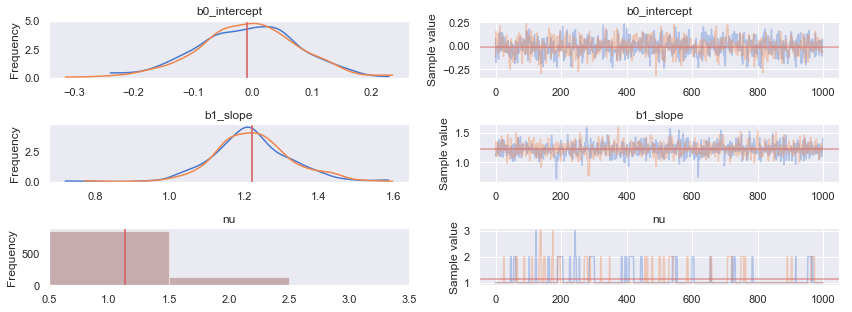

In [32]:
_ = pm.traceplot(traces_studentt[-1000:]
            ,figsize=(12,len(traces_studentt.varnames)*1.5)
            ,lines={k: v['mean'] for k, v in pm.summary(traces_studentt[-1000:]).iterrows()})

**Observe:**

+ Both parameters `b0` and `b1` show ...
+ The `nu` parameter seems very happy to stick at `nu = 1`, indicating that ...
+ The inference sampling also ran very ...

### Create Robust Model with Outliers: Hogg Method

Please read the paper (Hogg 2010) and Jake Vanderplas' code for more complete information about the modelling technique.

The general idea is to create a 'mixture' model whereby datapoints can be described by either the linear model (inliers) or a modified linear model with different mean and larger variance (outliers).


The likelihood is evaluated over a mixture of two likelihoods, one for 'inliers', one for 'outliers'. A Bernouilli distribution is used to randomly assign datapoints in N to either the inlier or outlier groups, and we sample the model as usual to infer robust model parameters and inlier / outlier flags:

$$
\mathcal{logL} = \sum_{i}^{i=N} log \left[ \frac{(1 - B_{i})}{\sqrt{2 \pi \sigma_{in}^{2}}} exp \left( - \frac{(x_{i} - \mu_{in})^{2}}{2\sigma_{in}^{2}} \right) \right] + \sum_{i}^{i=N} log \left[ \frac{B_{i}}{\sqrt{2 \pi (\sigma_{in}^{2} + \sigma_{out}^{2})}} exp \left( - \frac{(x_{i}- \mu_{out})^{2}}{2(\sigma_{in}^{2} + \sigma_{out}^{2})} \right) \right]
$$

where:  
$\bf{B}$ is Bernoulli-distibuted $B_{i} \in [0_{(inlier)},1_{(outlier)}]$



In [33]:
def logp_signoise(yobs, is_outlier, yest_in, sigma_y_in, yest_out, sigma_y_out):
    '''
    Define custom loglikelihood for inliers vs outliers. 
    NOTE: in this particular case we don't need to use theano's @as_op 
    decorator because (as stated by Twiecki in conversation) that's only 
    required if the likelihood cannot be expressed as a theano expression.
    We also now get the gradient computation for free.
    '''   
    
    # likelihood for inliers
    pdfs_in = T.exp(-(yobs - yest_in + 1e-4)**2 / (2 * sigma_y_in**2)) 
    pdfs_in /= T.sqrt(2 * np.pi * sigma_y_in**2)
    logL_in = T.sum(T.log(pdfs_in) * (1 - is_outlier))

    # likelihood for outliers
    pdfs_out = T.exp(-(yobs - yest_out + 1e-4)**2 / (2 * (sigma_y_in**2 + sigma_y_out**2))) 
    pdfs_out /= T.sqrt(2 * np.pi * (sigma_y_in**2 + sigma_y_out**2))
    logL_out = T.sum(T.log(pdfs_out) * is_outlier)

    return logL_in + logL_out


In [35]:
with pm.Model() as mdl_signoise:
    
    ## Define weakly informative Normal priors to give Ridge regression
    b0 = pm.Normal('b0_intercept', mu=0, sd=100)
    b1 = pm.Normal('b1_slope', mu=0, sd=100)
 
    ## Define linear model
    yest_in = b0 + b1 * dfhoggs['x']

    ## Define weakly informative priors for the mean and variance of outliers
    yest_out = pm.Normal('yest_out', mu=0, sd=100)
    sigma_y_out = pm.HalfNormal('sigma_y_out', sd=100)

    ## Define Bernoulli inlier / outlier flags according to a hyperprior 
    ## fraction of outliers, itself constrained to [0,.5] for symmetry
    frac_outliers = pm.Uniform('frac_outliers', lower=0., upper=.5)
    is_outlier = pm.Bernoulli('is_outlier', p=frac_outliers, shape=dfhoggs.shape[0])  
       
    ## Extract observed y and sigma_y from dataset, encode as theano objects
    yobs = thno.shared(np.asarray(dfhoggs['y'], dtype=thno.config.floatX), name='yobs')
    sigma_y_in = thno.shared(np.asarray(dfhoggs['sigma_y']
                                , dtype=thno.config.floatX), name='sigma_y_in')
        
    ## Use custom likelihood using DensityDist
    likelihood = pm.DensityDist('likelihood', logp_signoise,
                        observed={'yobs':yobs, 'is_outlier':is_outlier,
                                  'yest_in':yest_in, 'sigma_y_in':sigma_y_in,
                                  'yest_out':yest_out, 'sigma_y_out':sigma_y_out})


In [37]:
with mdl_signoise:

    ## two-step sampling to create Bernoulli inlier/outlier flags
    step1 = pm.NUTS([frac_outliers, yest_out, sigma_y_out, b0, b1])
    step2 = pm.BinaryMetropolis([is_outlier], tune_interval=100)

    ## find MAP using Powell, seems to be more robust
    start_MAP = pm.find_MAP(fmin=optimize.fmin_powell, disp=True)

    ## take samples
    traces_signoise = pm.sample(2000, start=start_MAP, step=[step1,step2], progressbar=True)

  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]

logp = -264.7:   0%|                                                                          | 0/5000 [00:00<?, ?it/s]

logp = -258.94:   0%|▏                                                              | 10/5000 [00:00<00:05, 909.10it/s]

logp = -258.94:   0%|▏                                                             | 20/5000 [00:00<00:04, 1052.54it/s]

logp = -258.62:   1%|▎                                                             | 30/5000 [00:00<00:04, 1111.27it/s]

logp = -258.62:   1%|▍                                                             | 40/5000 [00:00<00:04, 1025.43it/s]

logp = -258.62:   1%|▌                                                             | 50/5000 [00:00<00:04, 1020.43it/s]

logp = -164.72:   1%|▋                                                             | 60/5000 [00:00<00:04, 1052.59it/s]

logp = -155.46:   1%|▊                                                             | 70/5000 [00:00<00:04, 1076.98it/s]

logp = -155.46:   2%|▉                                                             | 80/5000 [00:00<00:04, 1111.13it/s]

logp = -155.46:   2%|█                                                             | 90/5000 [00:00<00:04, 1084.36it/s]

logp = -155.46:   2%|█▏                                                           | 100/5000 [00:00<00:04, 1111.06it/s]

logp = -886.97:   2%|█▎                                                           | 110/5000 [00:00<00:04, 1100.04it/s]

logp = -886.97:   2%|█▎                                                           | 111/5000 [00:00<00:04, 1088.27it/s]

logp = -155.44:   2%|█▍                                                           | 120/5000 [00:00<00:04, 1088.27it/s]

logp = -155.44:   3%|█▌                                                           | 130/5000 [00:00<00:04, 1088.27it/s]

logp = -155.44:   3%|█▋                                                           | 140/5000 [00:00<00:04, 1088.27it/s]

logp = -155.44:   3%|█▊                                                           | 150/5000 [00:00<00:04, 1088.27it/s]

logp = -155.44:   3%|█▉                                                           | 160/5000 [00:00<00:04, 1088.27it/s]

logp = -155.44:   3%|██                                                           | 170/5000 [00:00<00:04, 1088.27it/s]

logp = -155.44:   4%|██▏                                                          | 180/5000 [00:00<00:04, 1088.27it/s]

logp = -155.44:   4%|██▎                                                          | 190/5000 [00:00<00:04, 1088.27it/s]

logp = -155.44:   4%|██▍                                                          | 200/5000 [00:00<00:04, 1088.27it/s]

logp = -155.44:   4%|██▌                                                          | 210/5000 [00:00<00:04, 1088.27it/s]

logp = -155.44:   4%|██▌                                                          | 212/5000 [00:00<00:04, 1060.17it/s]

logp = -155.44:   4%|██▋                                                          | 220/5000 [00:00<00:04, 1060.17it/s]

Optimization terminated successfully.

         Current function value: 155.439668

         Iterations: 3

         Function evaluations: 227

logp = -155.44:   5%|██▊                                                           | 227/5000 [00:00<00:06, 769.49it/s]

Multiprocess sampling (2 chains in 2 jobs)

CompoundStep

>NUTS: [b1_slope, b0_intercept, sigma_y_out_log__, yest_out, frac_outliers_interval__]

>BinaryMetropolis: [is_outlier]

Could not pickle model, sampling singlethreaded.

Sequential sampling (2 chains in 1 job)

CompoundStep

>NUTS: [b1_slope, b0_intercept, sigma_y_out_log__, yest_out, frac_outliers_interval__]

>BinaryMetropolis: [is_outlier]

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "C:\Users\nekit\Anaconda3\lib\site-packages\joblib\externals\loky\backend\queues.py", line 150, in _feed
    obj_ = dumps(obj, reducers=reducers)
  File "C:\Users\nekit\Anaconda3\lib\site-packages\joblib\externals\loky\backend\reduction.py", line 243, in dumps
    dump(obj, buf, reducers=reducers, protocol=protocol)
  File "C:\Users\nekit\Anaconda3\lib\site-packages\joblib\externals\loky\backend\reduction.py", line 236, in dump
    _LokyPickler(file, reducers=reducers, protocol=protocol).dump(obj)
  File "C:\Users\nekit\Anaconda3\lib\site-packages\joblib\externals\cloudpickle\cloudpickle.py", line 267, in dump
    return Pickler.dump(self, obj)
  File "C:\Users\nekit\Anaconda3\lib\pickle.py", line 409, in dump
    self.save(obj)
  File "C:\Users\nekit\Anaconda3\lib\pickle.py", line 521, in save
    self.save_reduce(obj=obj, *rv)
  File "C:\Users\nekit\Anaconda3\lib\pickle.py", line 634, in save_reduce
    

  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

  0%|                                                                                 | 1/2500 [00:00<11:24,  3.65it/s]

  1%|▍                                                                               | 13/2500 [00:00<08:08,  5.10it/s]

  1%|▊                                                                               | 26/2500 [00:00<05:48,  7.09it/s]

  1%|█▏                                                                              | 37/2500 [00:00<04:11,  9.80it/s]

  2%|█▌                                                                              | 47/2500 [00:00<03:04, 13.31it/s]

  2%|█▊                                                                              | 57/2500 [00:00<02:16, 17.88it/s]

  3%|██▏                                                                             | 69/2500 [00:01<01:42, 23.78it/s]

  3%|██▌                                                                             | 81/2500 [00:01<01:17, 31.23it/s]

  4%|███                                                                             | 96/2500 [00:01<00:59, 40.66it/s]

  4%|███▌                                                                           | 112/2500 [00:01<00:46, 51.83it/s]

  5%|███▉                                                                           | 126/2500 [00:01<00:37, 63.29it/s]

  6%|████▍                                                                          | 139/2500 [00:01<00:32, 72.92it/s]

  6%|████▊                                                                          | 151/2500 [00:01<00:29, 80.16it/s]

  7%|█████▏                                                                         | 166/2500 [00:01<00:25, 92.32it/s]

  7%|█████▋                                                                        | 184/2500 [00:01<00:21, 107.92it/s]

  8%|██████▏                                                                       | 198/2500 [00:02<00:22, 103.78it/s]

  8%|██████▋                                                                        | 211/2500 [00:02<00:23, 97.54it/s]

  9%|███████▎                                                                      | 234/2500 [00:02<00:19, 117.91it/s]

 10%|███████▊                                                                      | 252/2500 [00:02<00:17, 131.52it/s]

 11%|████████▋                                                                     | 277/2500 [00:02<00:14, 153.03it/s]

 12%|█████████▏                                                                    | 296/2500 [00:02<00:13, 160.87it/s]

 13%|█████████▊                                                                    | 316/2500 [00:02<00:12, 170.90it/s]

 14%|██████████▌                                                                   | 340/2500 [00:02<00:11, 185.75it/s]

 15%|███████████▍                                                                  | 368/2500 [00:02<00:10, 204.80it/s]

 16%|████████████▏                                                                 | 391/2500 [00:03<00:10, 209.45it/s]

 17%|████████████▉                                                                 | 416/2500 [00:03<00:09, 218.43it/s]

 18%|█████████████▋                                                                | 439/2500 [00:03<00:09, 212.56it/s]

 18%|██████████████▍                                                               | 461/2500 [00:03<00:10, 201.19it/s]

 19%|███████████████                                                               | 482/2500 [00:03<00:10, 186.89it/s]

 20%|███████████████▋                                                              | 502/2500 [00:03<00:10, 189.02it/s]

 21%|████████████████▎                                                             | 522/2500 [00:03<00:12, 163.44it/s]

 22%|█████████████████▏                                                            | 551/2500 [00:03<00:10, 186.96it/s]

 23%|██████████████████                                                            | 580/2500 [00:04<00:09, 208.83it/s]

 24%|██████████████████▊                                                           | 603/2500 [00:04<00:09, 206.65it/s]

 25%|███████████████████▌                                                          | 626/2500 [00:04<00:08, 210.22it/s]

 26%|████████████████████▏                                                         | 649/2500 [00:04<00:08, 211.62it/s]

 27%|█████████████████████▏                                                        | 679/2500 [00:04<00:07, 231.60it/s]

 28%|█████████████████████▉                                                        | 704/2500 [00:04<00:07, 234.83it/s]

 29%|██████████████████████▉                                                       | 736/2500 [00:04<00:07, 246.93it/s]

 30%|███████████████████████▊                                                      | 762/2500 [00:04<00:07, 238.96it/s]

 31%|████████████████████████▌                                                     | 787/2500 [00:04<00:07, 222.75it/s]

 32%|█████████████████████████▎                                                    | 812/2500 [00:04<00:07, 227.77it/s]

 33%|██████████████████████████                                                    | 836/2500 [00:05<00:07, 223.54it/s]

 34%|██████████████████████████▊                                                   | 859/2500 [00:05<00:07, 213.52it/s]

 36%|███████████████████████████▋                                                  | 889/2500 [00:05<00:06, 232.10it/s]

 37%|████████████████████████████▌                                                 | 914/2500 [00:05<00:06, 235.19it/s]

 38%|█████████████████████████████▍                                                | 942/2500 [00:05<00:06, 245.11it/s]

 39%|██████████████████████████████▎                                               | 972/2500 [00:05<00:05, 257.33it/s]

 40%|██████████████████████████████▊                                              | 1002/2500 [00:05<00:05, 266.65it/s]

 41%|███████████████████████████████▊                                             | 1032/2500 [00:05<00:05, 274.33it/s]

 42%|████████████████████████████████▋                                            | 1060/2500 [00:05<00:05, 266.56it/s]

 44%|█████████████████████████████████▋                                           | 1093/2500 [00:06<00:04, 282.87it/s]

 45%|██████████████████████████████████▌                                          | 1124/2500 [00:06<00:04, 290.50it/s]

 46%|███████████████████████████████████▋                                         | 1157/2500 [00:06<00:04, 300.50it/s]

 48%|████████████████████████████████████▌                                        | 1188/2500 [00:06<00:04, 266.52it/s]

 49%|█████████████████████████████████████▌                                       | 1221/2500 [00:06<00:04, 281.39it/s]

 50%|██████████████████████████████████████▌                                      | 1251/2500 [00:06<00:04, 281.09it/s]

 51%|███████████████████████████████████████▌                                     | 1283/2500 [00:06<00:04, 290.94it/s]

 53%|████████████████████████████████████████▍                                    | 1313/2500 [00:06<00:04, 285.23it/s]

 54%|█████████████████████████████████████████▎                                   | 1342/2500 [00:06<00:04, 280.81it/s]

 55%|██████████████████████████████████████████▏                                  | 1371/2500 [00:07<00:04, 273.10it/s]

 56%|███████████████████████████████████████████                                  | 1399/2500 [00:07<00:04, 259.80it/s]

 57%|███████████████████████████████████████████▉                                 | 1426/2500 [00:07<00:04, 252.47it/s]

 58%|████████████████████████████████████████████▋                                | 1452/2500 [00:07<00:04, 253.19it/s]

 59%|█████████████████████████████████████████████▌                               | 1478/2500 [00:07<00:04, 247.89it/s]

 60%|██████████████████████████████████████████████▍                              | 1507/2500 [00:07<00:03, 259.18it/s]

 61%|███████████████████████████████████████████████▏                             | 1534/2500 [00:07<00:03, 247.21it/s]

 62%|████████████████████████████████████████████████                             | 1560/2500 [00:07<00:03, 237.18it/s]

 64%|█████████████████████████████████████████████████▏                           | 1595/2500 [00:07<00:03, 261.39it/s]

 65%|██████████████████████████████████████████████████▏                          | 1631/2500 [00:08<00:03, 284.11it/s]

 67%|███████████████████████████████████████████████████▎                         | 1664/2500 [00:08<00:02, 295.68it/s]

 68%|████████████████████████████████████████████████████▏                        | 1695/2500 [00:08<00:03, 262.52it/s]

 69%|█████████████████████████████████████████████████████                        | 1723/2500 [00:08<00:03, 255.09it/s]

 70%|█████████████████████████████████████████████████████▉                       | 1750/2500 [00:08<00:03, 236.87it/s]

 71%|██████████████████████████████████████████████████████▋                      | 1775/2500 [00:08<00:03, 232.60it/s]

 72%|███████████████████████████████████████████████████████▌                     | 1803/2500 [00:08<00:02, 240.62it/s]

 73%|████████████████████████████████████████████████████████▌                    | 1835/2500 [00:08<00:02, 259.97it/s]

 74%|█████████████████████████████████████████████████████████▎                   | 1862/2500 [00:08<00:02, 240.43it/s]

 76%|██████████████████████████████████████████████████████████▏                  | 1889/2500 [00:09<00:02, 248.59it/s]

 77%|██████████████████████████████████████████████████████████▉                  | 1915/2500 [00:09<00:02, 250.45it/s]

 78%|███████████████████████████████████████████████████████████▊                 | 1943/2500 [00:09<00:02, 257.21it/s]

 79%|████████████████████████████████████████████████████████████▊                | 1974/2500 [00:09<00:01, 269.65it/s]

 80%|█████████████████████████████████████████████████████████████▋               | 2004/2500 [00:09<00:01, 275.78it/s]

 81%|██████████████████████████████████████████████████████████████▌              | 2032/2500 [00:09<00:01, 265.23it/s]

 82%|███████████████████████████████████████████████████████████████▍             | 2059/2500 [00:09<00:01, 258.23it/s]

 84%|████████████████████████████████████████████████████████████████▍            | 2092/2500 [00:09<00:01, 273.51it/s]

 85%|█████████████████████████████████████████████████████████████████▎           | 2120/2500 [00:09<00:01, 264.49it/s]

 86%|██████████████████████████████████████████████████████████████████▏          | 2149/2500 [00:10<00:01, 270.14it/s]

 87%|███████████████████████████████████████████████████████████████████          | 2177/2500 [00:10<00:01, 252.36it/s]

 88%|███████████████████████████████████████████████████████████████████▉         | 2204/2500 [00:10<00:01, 256.67it/s]

 89%|████████████████████████████████████████████████████████████████████▋        | 2230/2500 [00:10<00:01, 237.86it/s]

 90%|█████████████████████████████████████████████████████████████████████▌       | 2258/2500 [00:10<00:00, 247.79it/s]

 91%|██████████████████████████████████████████████████████████████████████▎      | 2284/2500 [00:10<00:00, 246.33it/s]

 93%|███████████████████████████████████████████████████████████████████████▍     | 2320/2500 [00:10<00:00, 268.45it/s]

 94%|████████████████████████████████████████████████████████████████████████▎    | 2349/2500 [00:10<00:00, 273.02it/s]

 95%|█████████████████████████████████████████████████████████████████████████▎   | 2379/2500 [00:10<00:00, 280.59it/s]

 96%|██████████████████████████████████████████████████████████████████████████▎  | 2412/2500 [00:11<00:00, 292.23it/s]

 98%|███████████████████████████████████████████████████████████████████████████▎ | 2444/2500 [00:11<00:00, 299.18it/s]

 99%|████████████████████████████████████████████████████████████████████████████▏| 2475/2500 [00:11<00:00, 284.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:11<00:00, 219.53it/s]

  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

  0%|                                                                                 | 1/2500 [00:00<05:32,  7.52it/s]

  1%|▋                                                                               | 21/2500 [00:00<03:54, 10.56it/s]

  1%|▉                                                                               | 31/2500 [00:00<02:51, 14.36it/s]

  2%|█▍                                                                              | 46/2500 [00:00<02:04, 19.64it/s]

  2%|█▉                                                                              | 59/2500 [00:00<01:32, 26.25it/s]

  3%|██▌                                                                             | 79/2500 [00:00<01:08, 35.41it/s]

  4%|██▉                                                                             | 93/2500 [00:00<00:52, 45.50it/s]

  4%|███▎                                                                           | 106/2500 [00:00<00:43, 55.44it/s]

  5%|███▊                                                                           | 119/2500 [00:00<00:35, 66.86it/s]

  6%|████▎                                                                          | 138/2500 [00:01<00:28, 82.78it/s]

  7%|█████▏                                                                        | 165/2500 [00:01<00:22, 104.40it/s]

  8%|██████                                                                        | 193/2500 [00:01<00:17, 128.59it/s]

  9%|███████                                                                       | 226/2500 [00:01<00:14, 156.97it/s]

 10%|███████▊                                                                      | 251/2500 [00:01<00:12, 175.57it/s]

 11%|████████▋                                                                     | 280/2500 [00:01<00:11, 198.74it/s]

 12%|█████████▌                                                                    | 306/2500 [00:01<00:10, 212.29it/s]

 13%|██████████▎                                                                   | 332/2500 [00:01<00:09, 222.92it/s]

 14%|███████████▏                                                                  | 358/2500 [00:01<00:09, 224.44it/s]

 15%|███████████▉                                                                  | 383/2500 [00:02<00:10, 198.46it/s]

 16%|████████████▋                                                                 | 405/2500 [00:02<00:10, 201.65it/s]

 17%|█████████████▎                                                                | 427/2500 [00:02<00:10, 201.16it/s]

 18%|██████████████▏                                                               | 454/2500 [00:02<00:09, 216.77it/s]

 19%|███████████████                                                               | 482/2500 [00:02<00:08, 231.94it/s]

 20%|███████████████▊                                                              | 507/2500 [00:02<00:09, 210.17it/s]

 21%|████████████████▋                                                             | 534/2500 [00:02<00:08, 225.14it/s]

 22%|█████████████████▍                                                            | 558/2500 [00:02<00:08, 225.52it/s]

 23%|██████████████████▎                                                           | 585/2500 [00:02<00:08, 236.62it/s]

 24%|███████████████████                                                           | 610/2500 [00:03<00:07, 239.79it/s]

 25%|███████████████████▊                                                          | 636/2500 [00:03<00:07, 244.11it/s]

 26%|████████████████████▋                                                         | 662/2500 [00:03<00:07, 245.85it/s]

 28%|█████████████████████▍                                                        | 688/2500 [00:03<00:07, 247.79it/s]

 29%|██████████████████████▏                                                       | 713/2500 [00:03<00:07, 244.08it/s]

 30%|███████████████████████                                                       | 738/2500 [00:03<00:07, 223.42it/s]

 30%|███████████████████████▋                                                      | 761/2500 [00:03<00:08, 212.84it/s]

 31%|████████████████████████▌                                                     | 787/2500 [00:03<00:07, 223.35it/s]

 33%|█████████████████████████▋                                                    | 822/2500 [00:03<00:06, 249.48it/s]

 34%|██████████████████████████▍                                                   | 849/2500 [00:04<00:07, 215.04it/s]

 35%|███████████████████████████▏                                                  | 873/2500 [00:04<00:07, 208.11it/s]

 36%|███████████████████████████▉                                                  | 896/2500 [00:04<00:08, 195.63it/s]

 37%|████████████████████████████▋                                                 | 919/2500 [00:04<00:07, 204.27it/s]

 38%|█████████████████████████████▎                                                | 941/2500 [00:04<00:07, 198.57it/s]

 39%|██████████████████████████████                                                | 963/2500 [00:04<00:07, 195.81it/s]

 39%|██████████████████████████████▋                                               | 984/2500 [00:04<00:08, 185.07it/s]

 40%|███████████████████████████████                                              | 1008/2500 [00:04<00:07, 193.43it/s]

 41%|███████████████████████████████▋                                             | 1029/2500 [00:05<00:07, 193.73it/s]

 42%|████████████████████████████████▎                                            | 1049/2500 [00:05<00:07, 193.86it/s]

 43%|████████████████████████████████▉                                            | 1071/2500 [00:05<00:07, 196.19it/s]

 44%|█████████████████████████████████▌                                           | 1091/2500 [00:05<00:07, 196.73it/s]

 44%|██████████████████████████████████▏                                          | 1111/2500 [00:05<00:07, 187.69it/s]

 45%|██████████████████████████████████▊                                          | 1130/2500 [00:05<00:07, 186.71it/s]

 46%|███████████████████████████████████▍                                         | 1149/2500 [00:05<00:07, 181.24it/s]

 47%|████████████████████████████████████▎                                        | 1181/2500 [00:05<00:06, 207.53it/s]

 48%|█████████████████████████████████████                                        | 1205/2500 [00:05<00:06, 213.43it/s]

 49%|█████████████████████████████████████▊                                       | 1228/2500 [00:05<00:05, 213.88it/s]

 50%|██████████████████████████████████████▌                                      | 1251/2500 [00:06<00:06, 207.81it/s]

 51%|███████████████████████████████████████▍                                     | 1282/2500 [00:06<00:05, 230.10it/s]

 52%|████████████████████████████████████████▎                                    | 1309/2500 [00:06<00:04, 238.87it/s]

 53%|█████████████████████████████████████████                                    | 1335/2500 [00:06<00:04, 243.46it/s]

 54%|█████████████████████████████████████████▉                                   | 1360/2500 [00:06<00:04, 235.01it/s]

 55%|██████████████████████████████████████████▋                                  | 1385/2500 [00:06<00:04, 228.80it/s]

 56%|███████████████████████████████████████████▍                                 | 1409/2500 [00:06<00:05, 216.94it/s]

 57%|████████████████████████████████████████████▏                                | 1436/2500 [00:06<00:04, 228.20it/s]

 58%|████████████████████████████████████████████▉                                | 1460/2500 [00:06<00:04, 228.31it/s]

 60%|█████████████████████████████████████████████▊                               | 1489/2500 [00:07<00:04, 243.26it/s]

 61%|██████████████████████████████████████████████▋                              | 1514/2500 [00:07<00:04, 236.21it/s]

 62%|███████████████████████████████████████████████▍                             | 1539/2500 [00:07<00:04, 238.12it/s]

 63%|████████████████████████████████████████████████▏                            | 1565/2500 [00:07<00:03, 242.24it/s]

 64%|█████████████████████████████████████████████████                            | 1591/2500 [00:07<00:03, 246.61it/s]

 65%|█████████████████████████████████████████████████▊                           | 1616/2500 [00:07<00:03, 227.35it/s]

 66%|██████████████████████████████████████████████████▊                          | 1649/2500 [00:07<00:03, 250.75it/s]

 67%|███████████████████████████████████████████████████▊                         | 1682/2500 [00:07<00:03, 266.93it/s]

 68%|████████████████████████████████████████████████████▋                        | 1710/2500 [00:07<00:03, 257.29it/s]

 70%|█████████████████████████████████████████████████████▌                       | 1739/2500 [00:08<00:02, 264.84it/s]

 71%|██████████████████████████████████████████████████████▍                      | 1767/2500 [00:08<00:02, 255.93it/s]

 72%|███████████████████████████████████████████████████████▎                     | 1795/2500 [00:08<00:02, 256.21it/s]

 73%|████████████████████████████████████████████████████████                     | 1821/2500 [00:08<00:03, 218.42it/s]

 74%|████████████████████████████████████████████████████████▉                    | 1847/2500 [00:08<00:02, 226.43it/s]

 75%|█████████████████████████████████████████████████████████▋                   | 1871/2500 [00:08<00:02, 224.52it/s]

 76%|██████████████████████████████████████████████████████████▎                  | 1895/2500 [00:08<00:02, 227.65it/s]

 77%|███████████████████████████████████████████████████████████                  | 1919/2500 [00:08<00:02, 215.05it/s]

 78%|███████████████████████████████████████████████████████████▉                 | 1946/2500 [00:08<00:02, 229.04it/s]

 79%|████████████████████████████████████████████████████████████▋                | 1970/2500 [00:09<00:02, 231.55it/s]

 80%|█████████████████████████████████████████████████████████████▌               | 1998/2500 [00:09<00:02, 242.32it/s]

 81%|██████████████████████████████████████████████████████████████▍              | 2029/2500 [00:09<00:01, 258.66it/s]

 83%|███████████████████████████████████████████████████████████████▌             | 2064/2500 [00:09<00:01, 279.29it/s]

 84%|████████████████████████████████████████████████████████████████▍            | 2093/2500 [00:09<00:01, 251.55it/s]

 85%|█████████████████████████████████████████████████████████████████▎           | 2120/2500 [00:09<00:01, 249.69it/s]

 86%|██████████████████████████████████████████████████████████████████           | 2146/2500 [00:09<00:01, 218.32it/s]

 87%|███████████████████████████████████████████████████████████████████          | 2176/2500 [00:09<00:01, 236.62it/s]

 88%|███████████████████████████████████████████████████████████████████▊         | 2201/2500 [00:10<00:01, 228.60it/s]

 89%|████████████████████████████████████████████████████████████████████▊        | 2233/2500 [00:10<00:01, 246.56it/s]

 90%|█████████████████████████████████████████████████████████████████████▌       | 2260/2500 [00:10<00:00, 251.73it/s]

 91%|██████████████████████████████████████████████████████████████████████▍      | 2286/2500 [00:10<00:00, 252.68it/s]

 92%|███████████████████████████████████████████████████████████████████████▏     | 2312/2500 [00:10<00:00, 246.14it/s]

 94%|████████████████████████████████████████████████████████████████████████     | 2338/2500 [00:10<00:00, 237.14it/s]

 95%|████████████████████████████████████████████████████████████████████████▊    | 2364/2500 [00:10<00:00, 241.53it/s]

 96%|█████████████████████████████████████████████████████████████████████████▊   | 2395/2500 [00:10<00:00, 257.38it/s]

 97%|██████████████████████████████████████████████████████████████████████████▋  | 2423/2500 [00:10<00:00, 262.29it/s]

 98%|███████████████████████████████████████████████████████████████████████████▍ | 2450/2500 [00:10<00:00, 253.38it/s]

 99%|████████████████████████████████████████████████████████████████████████████▎| 2476/2500 [00:11<00:00, 251.63it/s]

100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:11<00:00, 223.73it/s]

Tuning was enabled throughout the whole trace.

Tuning was enabled throughout the whole trace.

The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.

The estimated number of effective samples is smaller than 200 for some parameters.

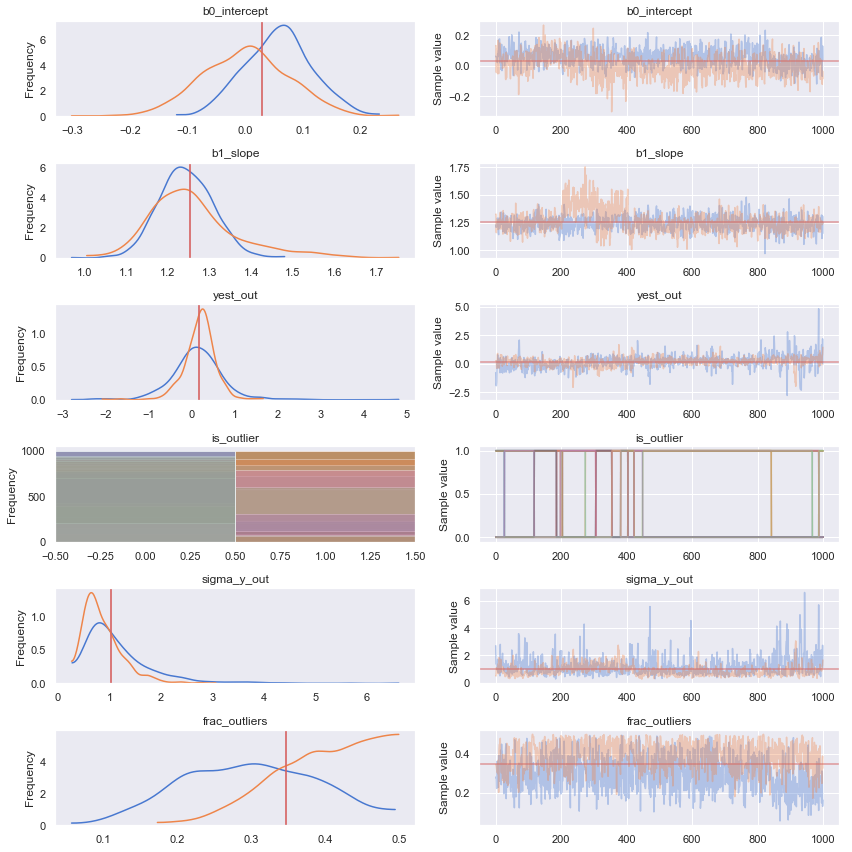

In [38]:
_ = pm.traceplot(traces_signoise[-1000:], figsize=(12,len(traces_signoise.varnames)*1.5),
            lines={k: v['mean'] for k, v in pm.summary(traces_signoise[-1000:]).iterrows()})

3 datapoints id=[1,2,3] are always indicated as outliers, but the remaining ordering of datapoints by decreasing outlier-hood is unstable between runs: the posterior surface appears to have a small number of solutions with very similar probability.

At each step of the traces, each datapoint may be either an inlier or outlier. We hope that the datapoints spend an unequal time being one state or the other, so let's take a look at the simple count of states for each of the 20 datapoints.

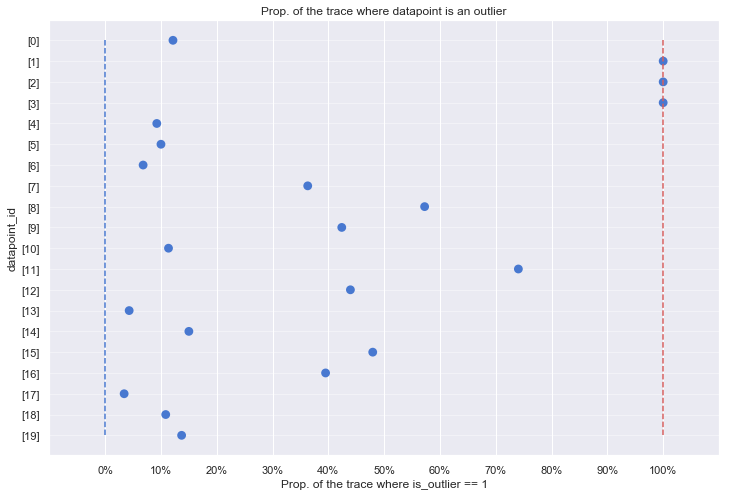

In [39]:
outlier_melt = pd.melt(pd.DataFrame(traces_signoise['is_outlier', -1000:],
                                   columns=['[{}]'.format(int(d)) for d in dfhoggs.index]),
                      var_name='datapoint_id', value_name='is_outlier')
ax0 = sns.pointplot(y='datapoint_id', x='is_outlier', data=outlier_melt,
                   kind='point', join=False, ci=None, size=4, aspect=2)

_ = ax0.vlines([0,1], 0, 19, ['b','r'], '--')

_ = ax0.set_xlim((-0.1,1.1))
_ = ax0.set_xticks(np.arange(0, 1.1, 0.1))
_ = ax0.set_xticklabels(['{:.0%}'.format(t) for t in np.arange(0,1.1,0.1)])

_ = ax0.yaxis.grid(True, linestyle='-', which='major', color='w', alpha=0.4)
_ = ax0.set_title('Prop. of the trace where datapoint is an outlier')
_ = ax0.set_xlabel('Prop. of the trace where is_outlier == 1')

**Observe**:

+ The plot above shows the number of samples in the traces in which each datapoint is marked as an outlier, expressed as a percentage.
+ In particular, 3 points [1, 2, 3] spend >=95% of their time as outliers
+ Contrastingly, points at the other end of the plot close to 0% are our strongest inliers.
+ For comparison, the mean posterior value of `frac_outliers` is ~0.35, corresponding to roughly 7 of the 20 datapoints. You can see these 7 datapoints in the plot above, all those with a value >50% or thereabouts.
+ However, only 3 of these points are outliers >=95% of the time. 
+ See note above regarding instability between runs.

The 95% cutoff we choose is subjective and arbitrary, but I prefer it for now, so let's declare these 3 to be outliers and see how it looks compared to Jake Vanderplas' outliers, which were declared in a slightly different way as points with means above 0.68.

+ I will declare outliers to be datapoints that have value == 1 at the 5-percentile cutoff, i.e. in the percentiles from 5 up to 100, their values are 1. 
+ Try for yourself altering cutoff to larger values, which leads to an objective ranking of outlier-hood.

In [40]:
cutoff = 5
dfhoggs['outlier'] = np.percentile(traces_signoise[-1000:]['is_outlier'],cutoff, axis=0)
dfhoggs['outlier'].value_counts()

0.0    17
1.0     3
Name: outlier, dtype: int64